In [1]:
import matplotlib as mpl
mpl.use('Agg')

In [2]:
from astropy import units as u

In [66]:
#Miles' packages
from astropy.table import Table
import astropy.coordinates as coord
import glob

#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections

#visualizations
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [14]:
stream_data_base = 'gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [88]:
print(len(stream_files))
stream_files[:5]

322


['gaia_mock_streams/stream-178.fits.gz',
 'gaia_mock_streams/stream-9528.fits.gz',
 'gaia_mock_streams/stream-9549.fits.gz',
 'gaia_mock_streams/stream-1954.fits.gz',
 'gaia_mock_streams/stream-2408.fits.gz']

Let's open one:

In [16]:
table = Table.read(stream_files[0], format='fits')
stream = table.to_pandas()

Let's plot it in ra/dec (angle coordinates):

(-90, 90)

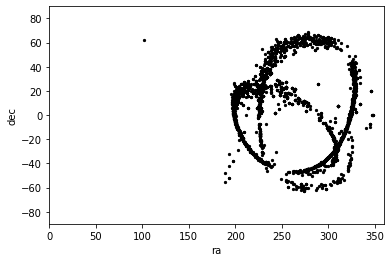

In [18]:
stream.plot('ra', 'dec', kind='scatter', s=5, color='k')
plt.xlim(0, 360)
plt.ylim(-90, 90)

Let's just take the part in this box:

In [19]:
stream = stream.query('ra > 200 & ra < 300 & dec < -20 & dec > -70')

In [20]:
len(stream)

477

This is very few stars. Typically we could expect > 1000. 

Now, let's add some foreground in this same region from the Gaia catalog:

In [21]:
!pip install -q astroquery

In [22]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


Now, let's download some random stars from Gaia around this region:

The important part is: "dr2.ra > 44.0 and dr2.ra < 54.0 and dr2.dec > -30.0 and dr2.dec < -10.0" - this represents the box around our data.

This is an SQL query to select 2,000 random stars matching our criteria (which we specify below)

In [23]:
min_ra = 200.0
max_ra = 300.0
min_dec = -70.0
max_dec = -20.0
max_rel_err = 0.5
n_points = 200

qry = f" \n\
select top {n_points} source_id, \n\
dr2.ra, \n\
dr2.dec, \n\
parallax, \n\
parallax_error, \n\
pmra, \n\
pmdec, \n\
phot_g_mean_mag,\n\
phot_bp_mean_mag, \n\
phot_rp_mean_mag, \n\
bp_rp, \n\
bp_g, \n\
g_rp\n\
from gaiadr2.gaia_source as dr2 \n\
where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
and parallax is not null \n\
and parallax_error is not null \n\
and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
and pmra is not null \n\
and pmdec is not null \n\
and phot_g_mean_mag is not null \n\
and phot_bp_mean_mag is not null \n\
and phot_rp_mean_mag is not null \n\
and bp_rp is not null \n\
and bp_g is not null \n\
and g_rp is not null \n\
order by random_index"

data = Gaia.launch_job_async(qry).get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


Here is our dataset plotted:

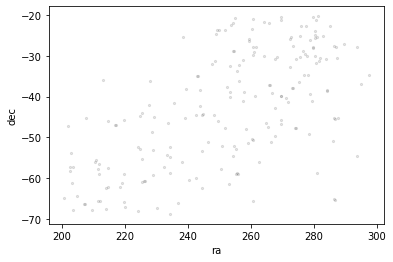

In [24]:
data.plot('ra', 'dec', kind='scatter', s=5, color='k', alpha=0.1)

Now, let's combine these datasets:

In [25]:
data['stream_mask'] = False
stream['stream_mask'] = True
data_to_search = pd.concat((data, stream), axis=0, ignore_index=True, sort=True)

In [33]:
data_to_search.head()

,bp_g,bp_rp,dec,g_rp,parallax,parallax_error,phot_bp_mean_mag,phot_g_mean_mag,phot_rp_mean_mag,pmdec,pmdec_error,pmra,pmra_error,ra,radial_velocity,source_id,stream_mask,parallax_over_error
0,0.745995,1.695269,-57.387303,0.949274,-0.061400,0.505920,20.300377,19.554382,18.605108,-1.351866,NaN,-7.782657,NaN,202.740334,NaN,6.062642e+18,False,-0.121364
1,0.348001,1.389643,-67.445328,1.041641,-0.080276,0.508523,20.407013,20.059011,19.017370,-3.854532,NaN,-7.949487,NaN,214.005417,NaN,5.847820e+18,False,-0.157862
2,0.050575,1.174305,-30.680420,1.123730,0.147487,0.314326,18.344303,18.293728,17.169998,-7.539622,NaN,-2.123922,NaN,274.212945,NaN,4.049405e+18,False,0.469215
3,-0.391691,1.616924,-25.163233,2.008615,0.131749,0.574607,19.043560,19.435251,17.426636,-4.444595,NaN,-3.810232,NaN,275.636451,NaN,4.053206e+18,False,0.229286
4,0.713690,1.577223,-52.253712,0.863533,0.035587,0.263006,19.482328,18.768639,17.905106,-1.521764,NaN,-0.452264,NaN,224.245063,NaN,5.900131e+18,False,0.135310


#### Consider that we wish to use stream_files[0] to train a supervised model using ra/dec/pmra/pmdec

In [37]:
data_supervised_train = data_to_search[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]
data_supervised_train.to_csv('file0point477noise200.csv')

In [90]:
min(stream_test.ra), max(stream_test.ra), min(stream_test.dec), max(stream_test.dec)

(0.24191268755049328,
 356.1523010192372,
 -62.041495244758345,
 74.63651371718082)

#### Consider all of the stream_files[i] as our test set

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


ValueError: scatter requires x column to be numeric

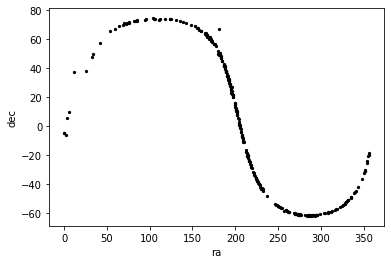

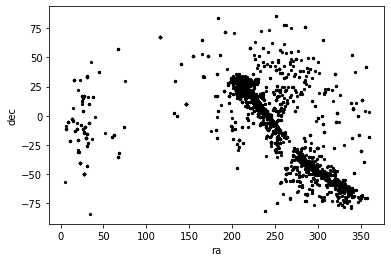

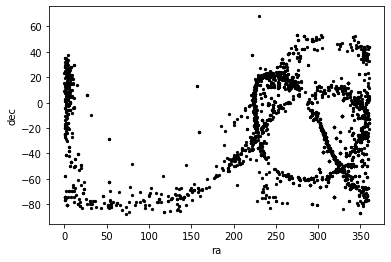

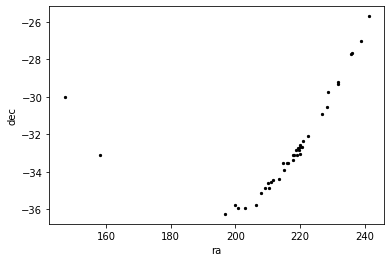

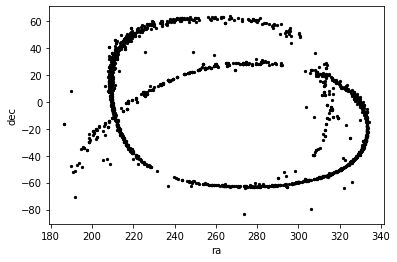

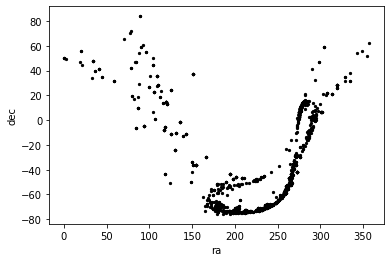

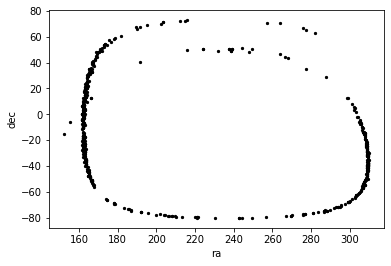

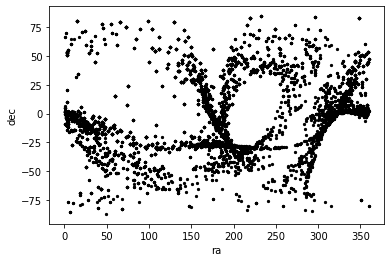

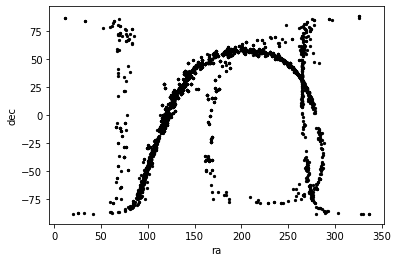

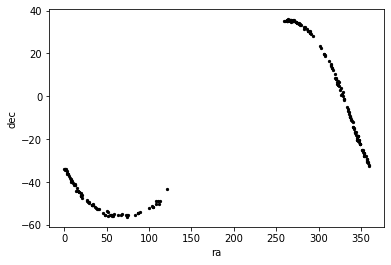

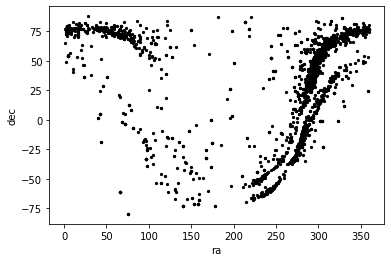

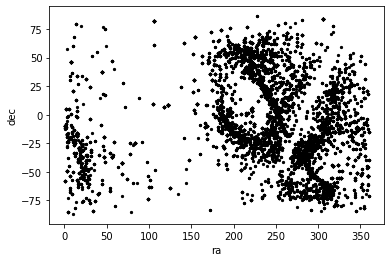

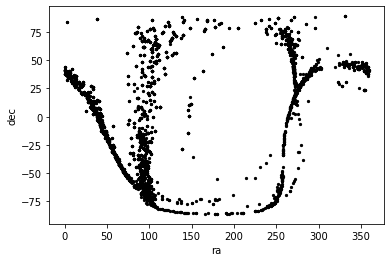

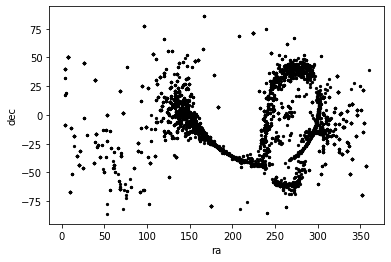

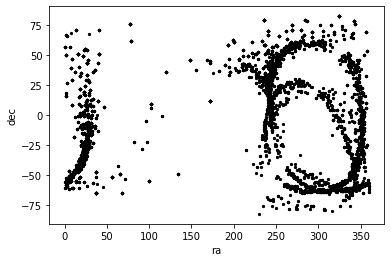

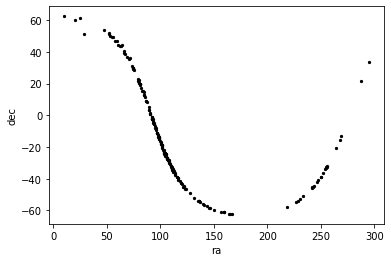

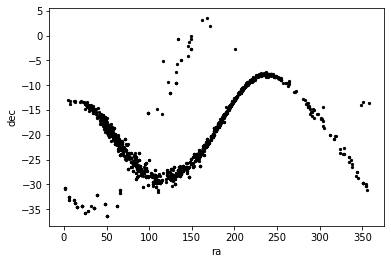

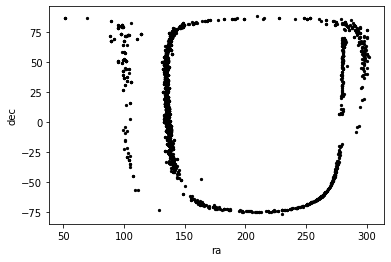

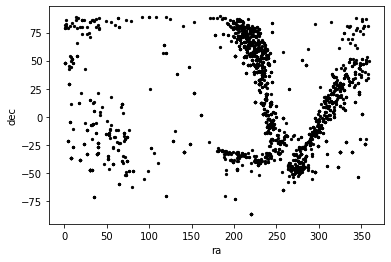

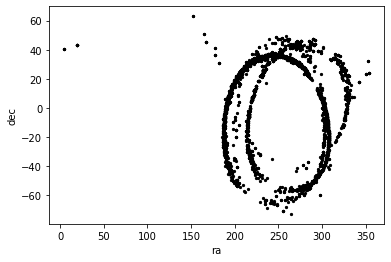

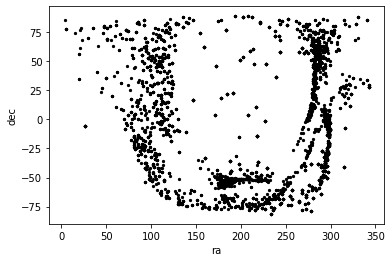

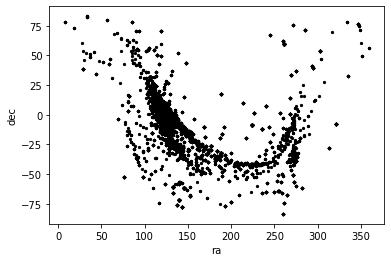

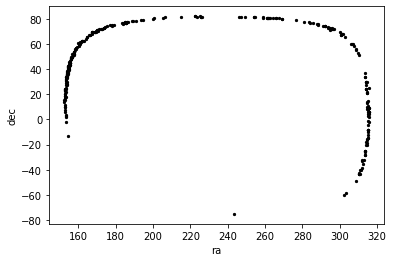

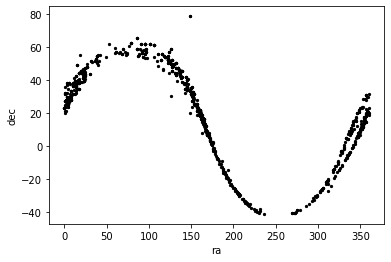

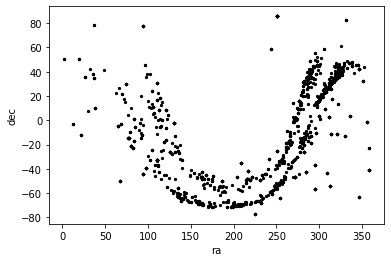

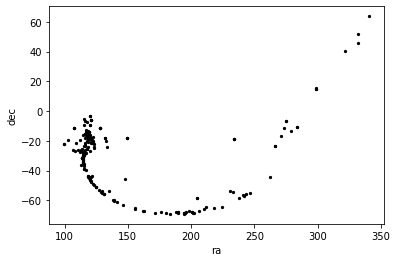

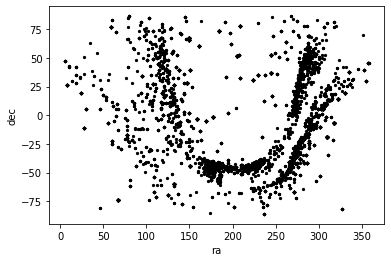

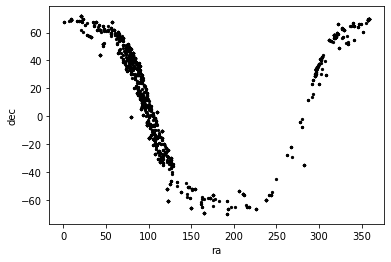

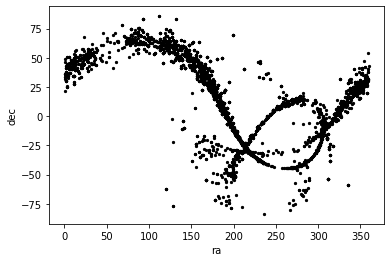

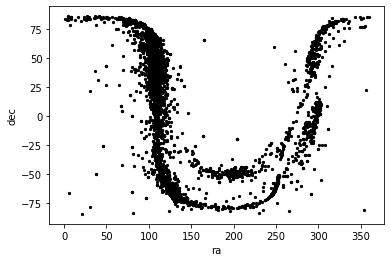

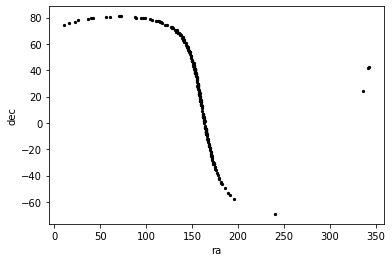

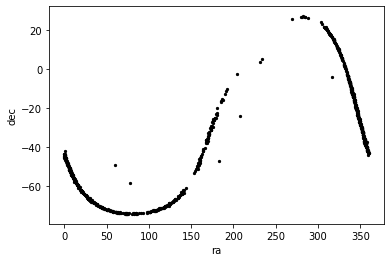

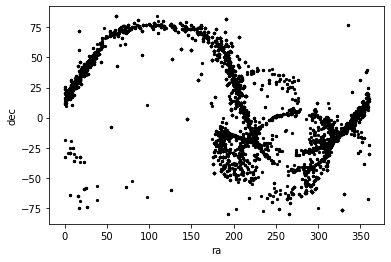

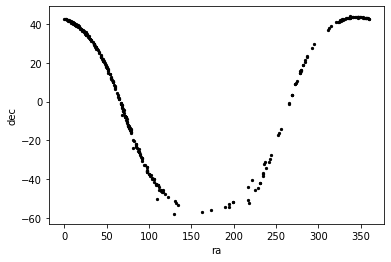

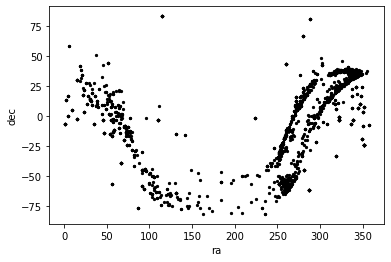

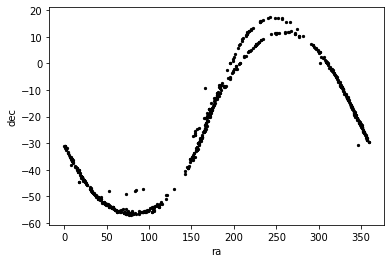

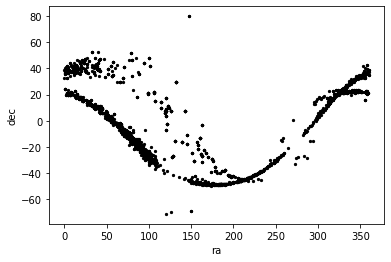

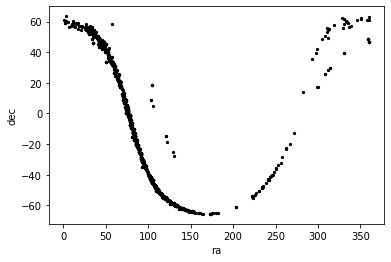

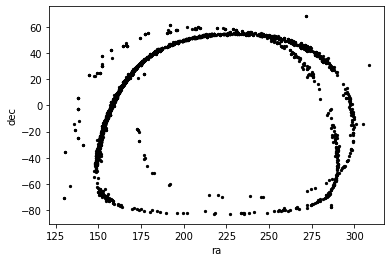

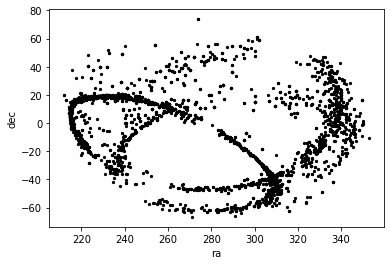

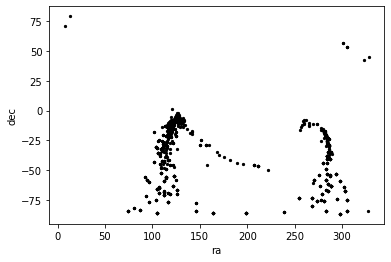

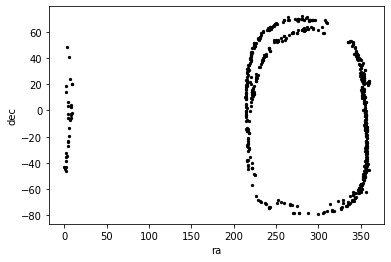

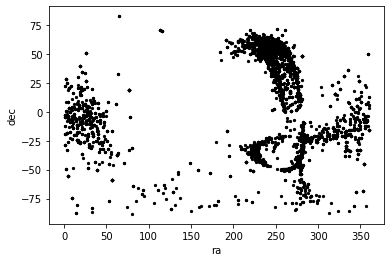

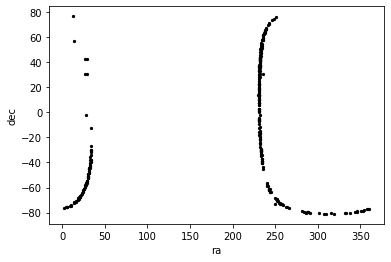

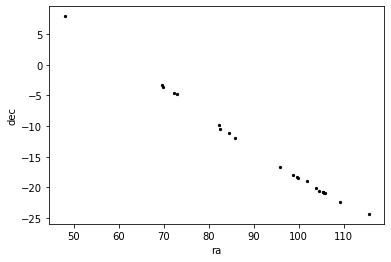

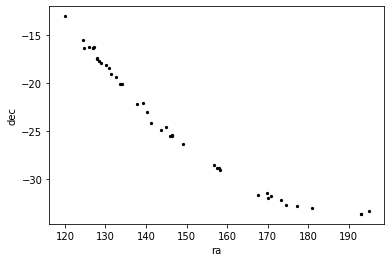

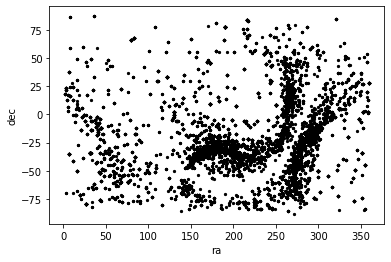

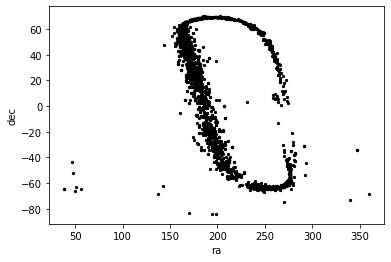

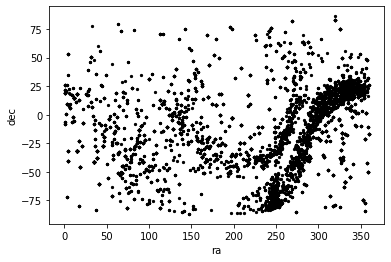

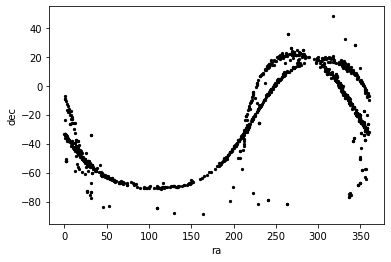

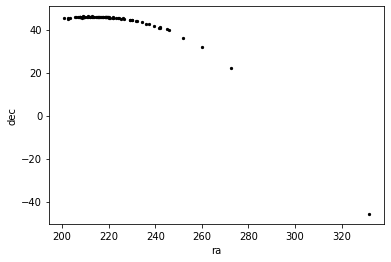

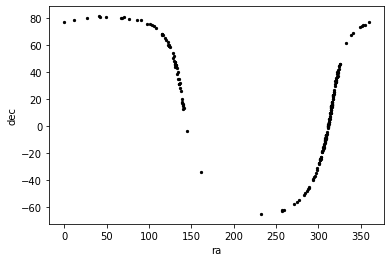

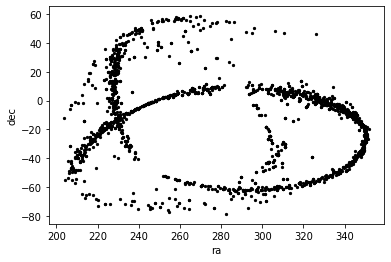

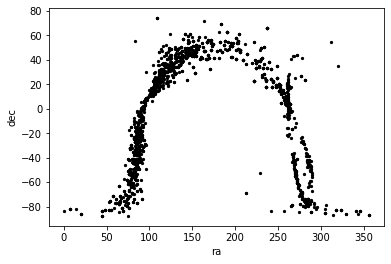

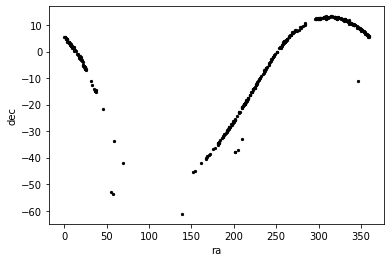

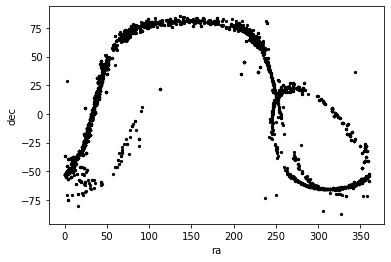

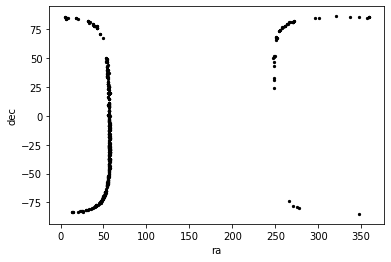

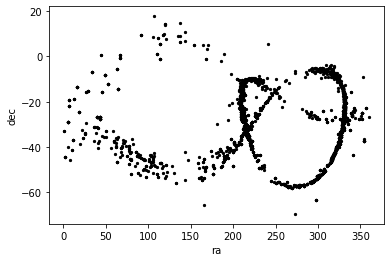

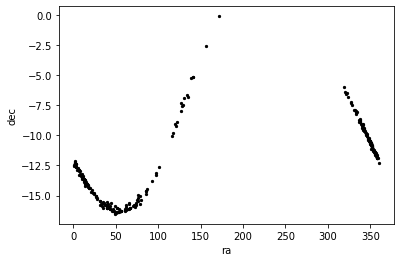

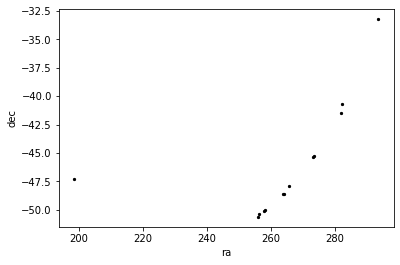

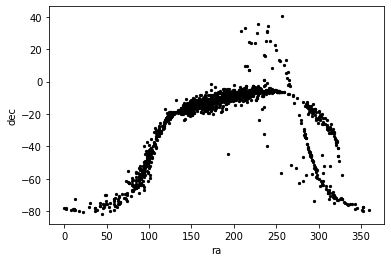

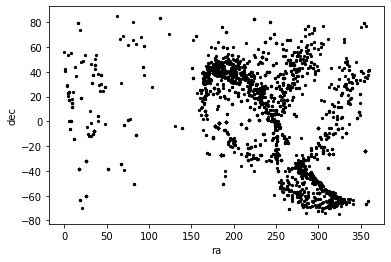

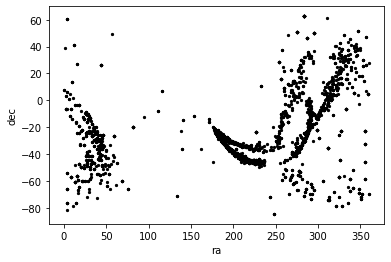

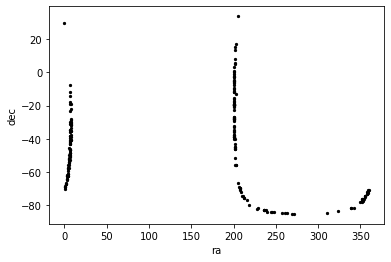

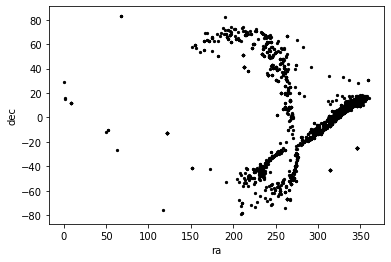

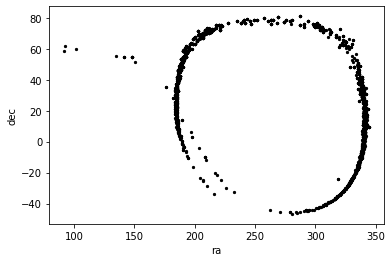

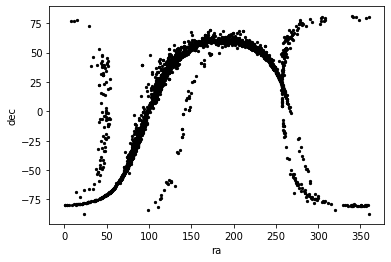

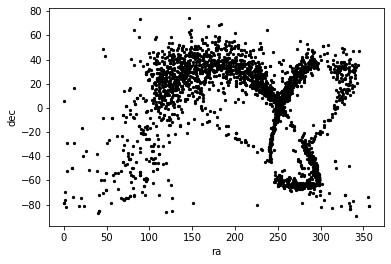

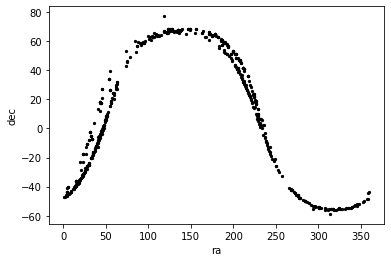

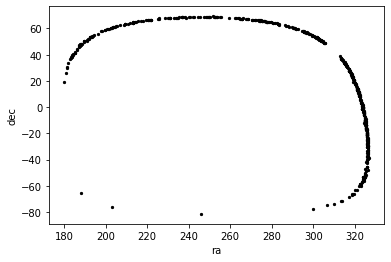

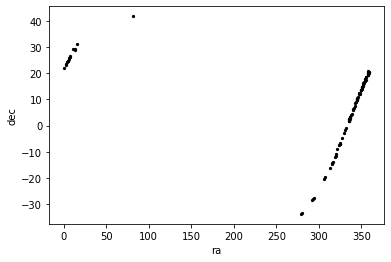

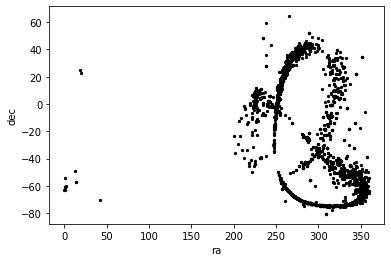

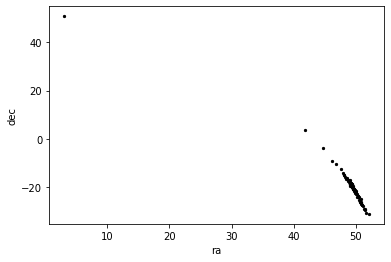

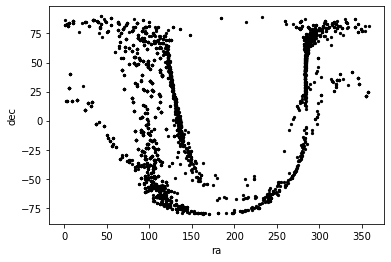

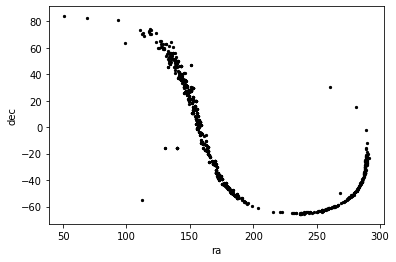

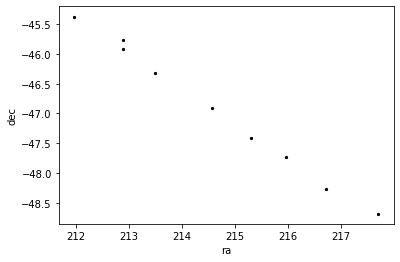

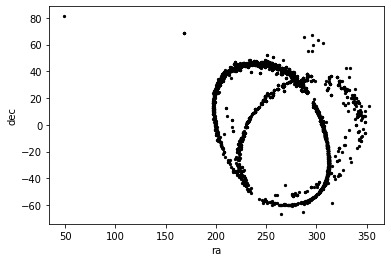

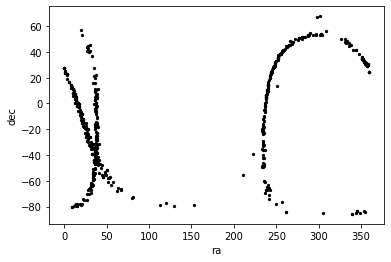

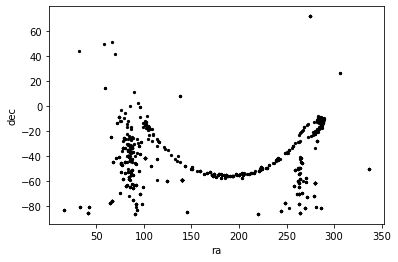

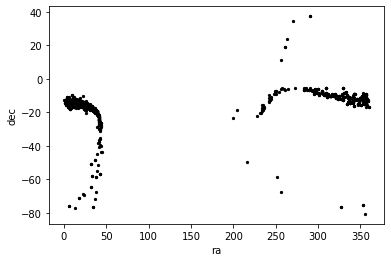

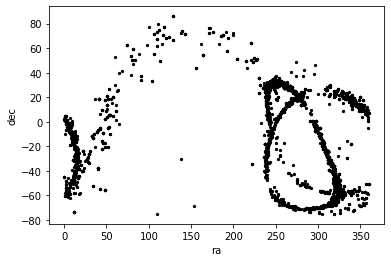

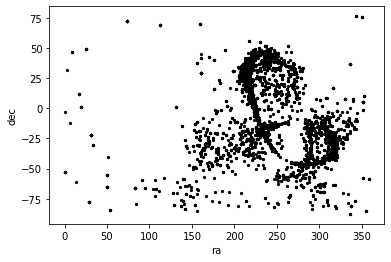

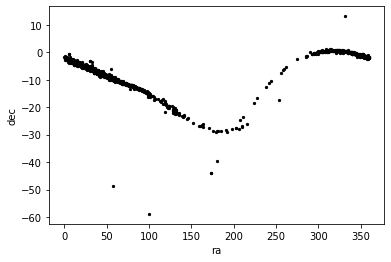

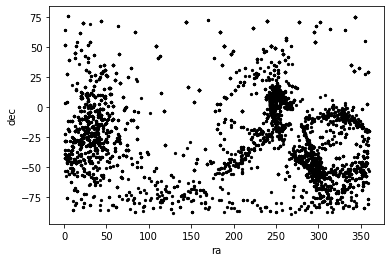

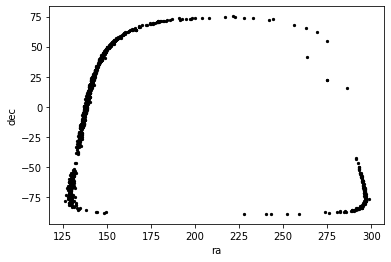

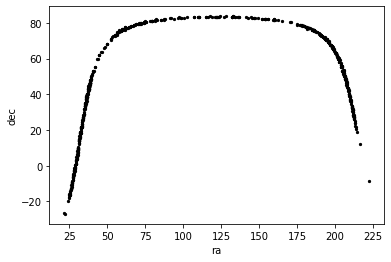

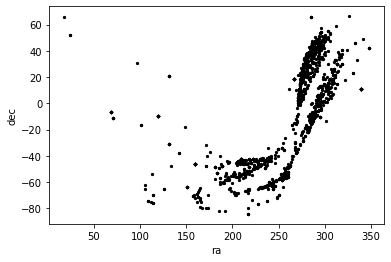

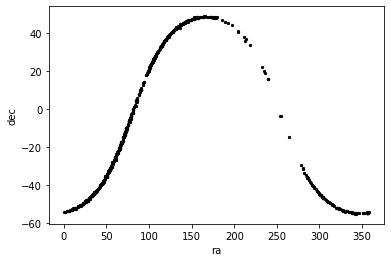

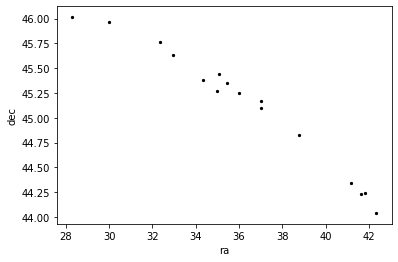

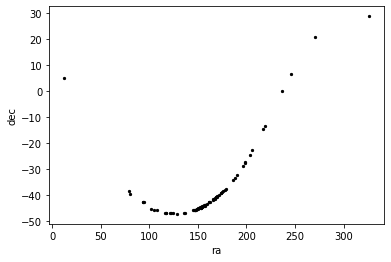

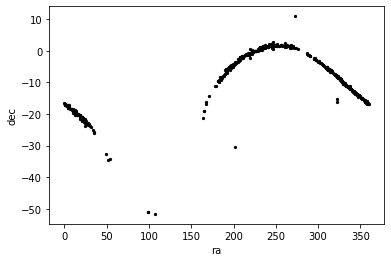

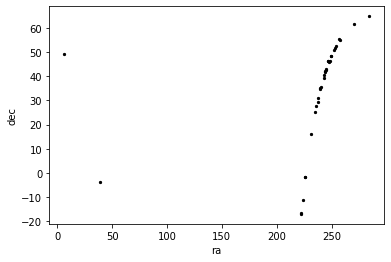

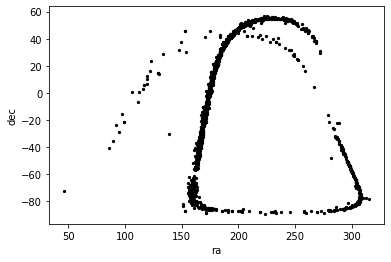

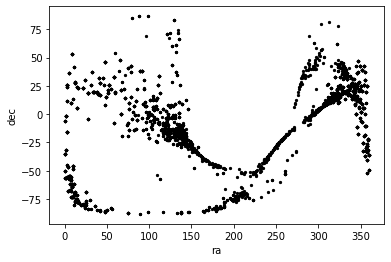

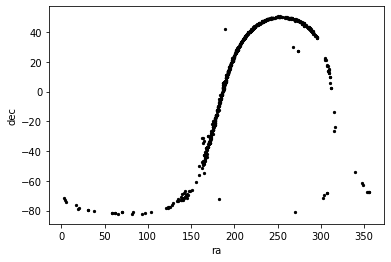

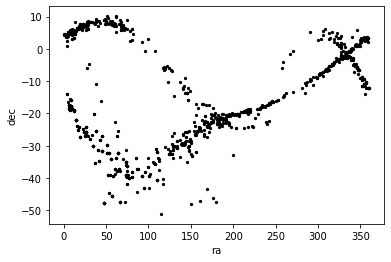

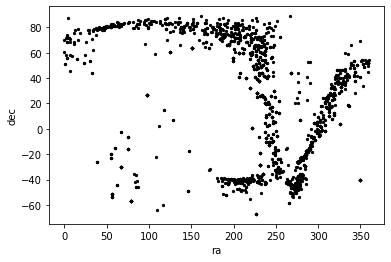

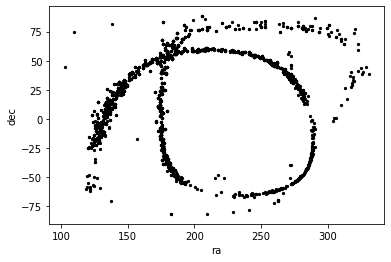

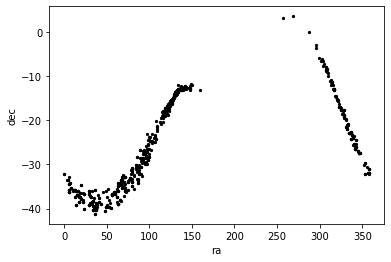

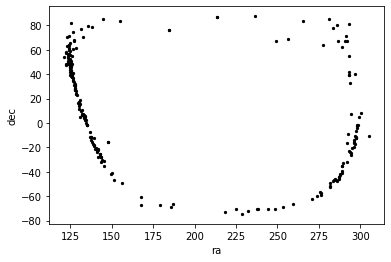

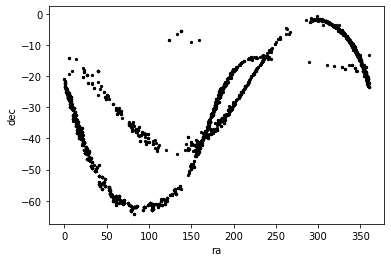

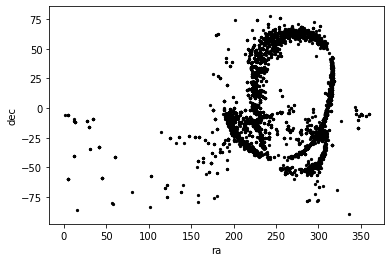

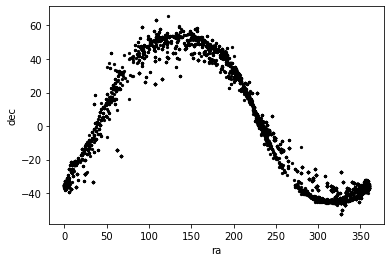

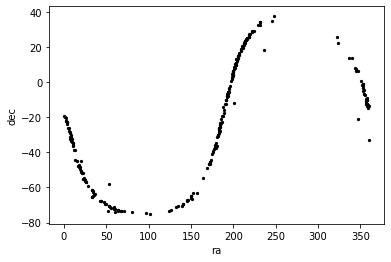

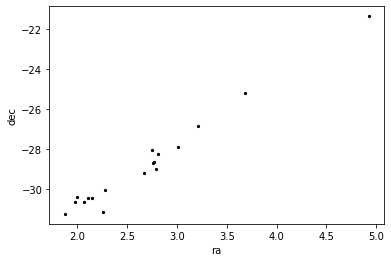

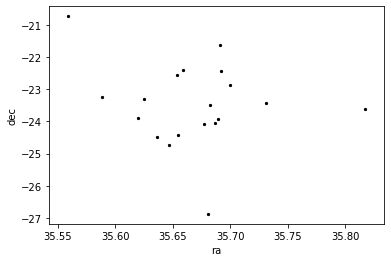

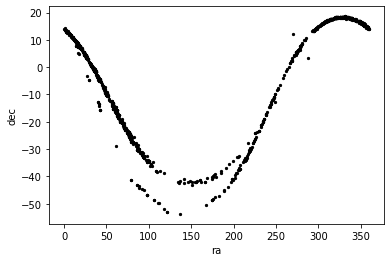

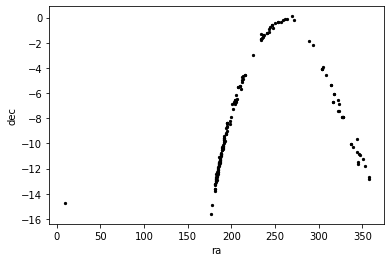

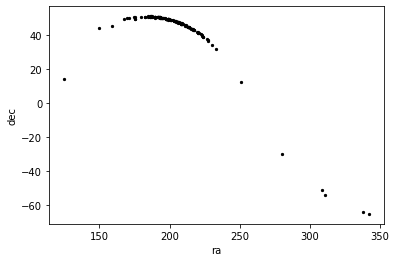

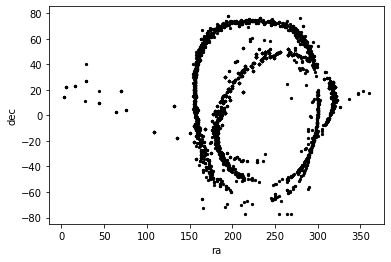

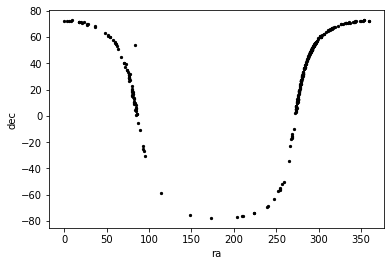

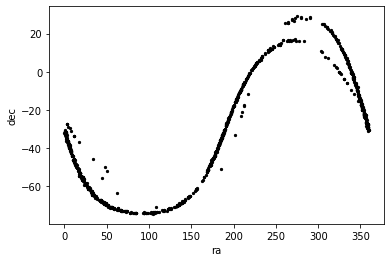

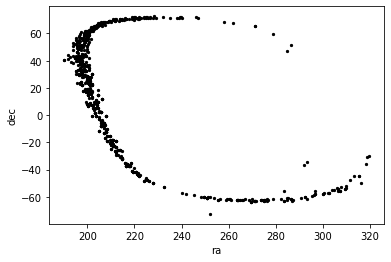

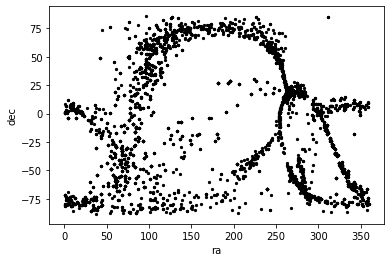

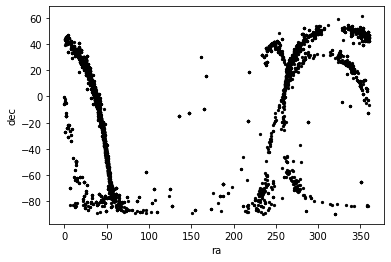

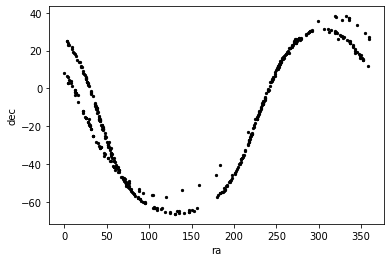

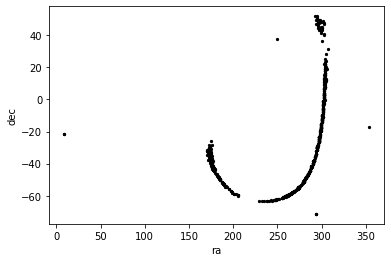

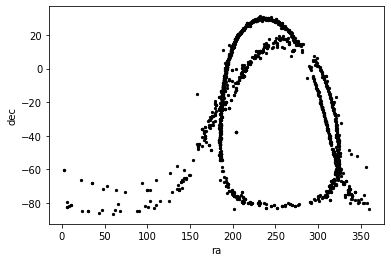

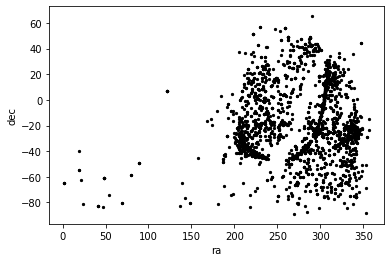

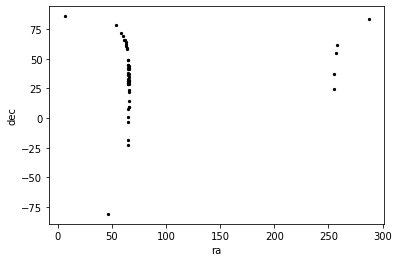

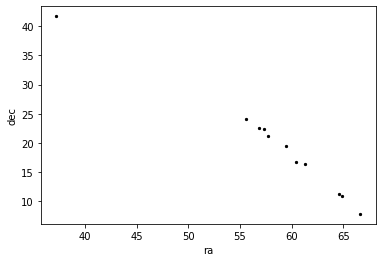

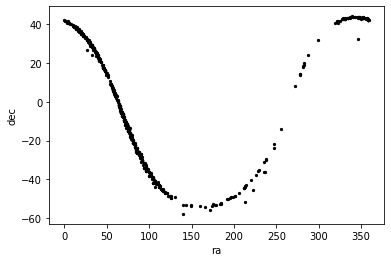

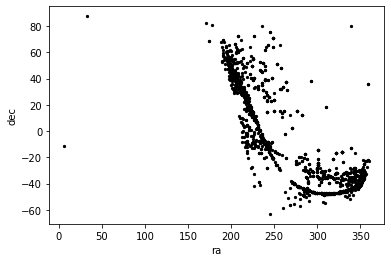

In [104]:
list_file_names = []

for i in range(1,len(stream_files)):
    table_test = Table.read(stream_files[i], format='fits')
    stream_test = table_test.to_pandas()
    stream_test.plot('ra', 'dec', kind='scatter', s=5, color='k')
    #plt.xlim(0, 360)
    #plt.ylim(-90, 90)
    #stream_test = stream_test.query('ra > 0 & ra < 400 & dec < 80 & dec > -70')
    #print('The length of the test data is ' + str(len(stream_test)))

    min_ra_test = min(stream_test.ra)-1
    max_ra_test = max(stream_test.ra)+1
    min_dec_test = min(stream_test.dec)-1
    max_dec_test = max(stream_test.dec)+1
    max_rel_err_test = 0.5
    n_points_test = 200

    qry = f" \n\
    select top {n_points_test} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra_test} and dr2.ra < {max_ra_test} and dr2.dec > {min_dec_test} and dr2.dec < {max_dec_test} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err_test} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_test = Gaia.launch_job_async(qry).get_results().to_pandas()

    #combine the data sets
    data_test['stream_mask'] = False
    stream_test['stream_mask'] = True
    data_test = pd.concat((data_test, stream_test), axis=0, ignore_index=True, sort=True)

    data_supervised_test = data_test[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]
    file_name = 'file' + str(i) + 'point' + str(len(stream_test))+ 'noise'+str(n_points_test)+'.csv'
    list_file_names.append(file_name)
    data_supervised_test.to_csv(file_name)


#### Let us try a simple logistic regression model on all the data points.

In [116]:
precisions_simulated = []
recalls_simulated = []
accuracy_simulated = []
auc_simulated = []

for i in list_file_names:
    training_data = pd.read_csv('file0point477noise200.csv', index_col = 0)
    testing_data = pd.read_csv(i, index_col = 0)
    
    #differentiate training and test data's X and y variables
    X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_train = training_data.stream_mask

    X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
    y_test = testing_data.stream_mask

    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_test).transform(X_test)
    
    precision_log_reg, recall_log_reg, accuracy_log_reg, auc_log_reg = log_reg_model(X_train, X_test, y_train, y_test)
    
    precisions_simulated.append(precision_log_reg)
    recalls_simulated.append(recall_log_reg)
    accuracy_simulated.append(accuracy_log_reg)
    auc_simulated.append(auc_log_reg)
    

/scratch/ao1584/myjupyter/ve2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/scratch/ao1584/myjupyter/ve2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/scratch/ao1584/myjupyter/ve2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/scratch/ao1584/myjupyter/ve2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



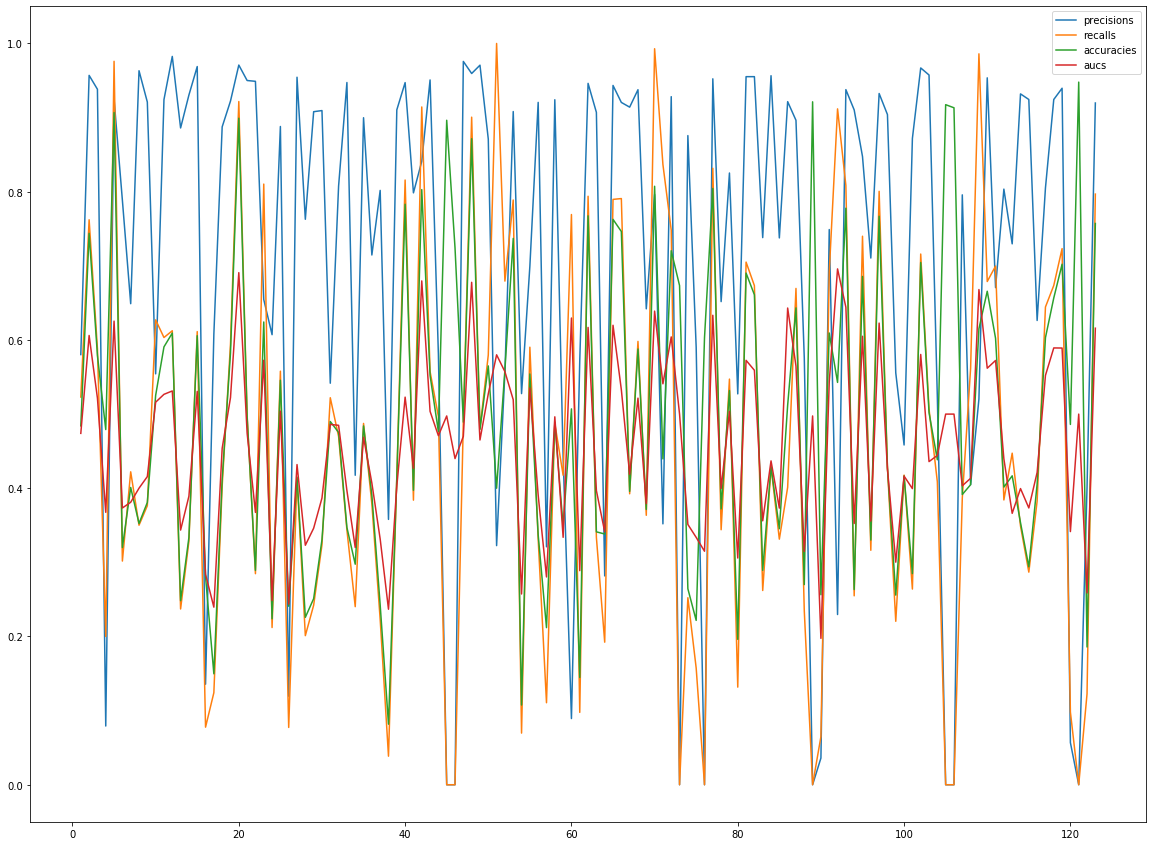

In [117]:
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(list_file_names)+1)]

plt.plot(simulated_streams_index, precisions_simulated, label = 'precisions')
plt.plot(simulated_streams_index, recalls_simulated, label = 'recalls')
plt.plot(simulated_streams_index, accuracy_simulated, label = 'accuracies')
plt.plot(simulated_streams_index, auc_simulated, label = 'aucs')

plt.legend()


In [118]:
precisions_simulated

[0.5802919708029197,
 0.9569471624266145,
 0.9382086167800453,
 0.07920792079207921,
 0.924792531120332,
 0.7885714285714286,
 0.648936170212766,
 0.9632107023411371,
 0.920957215373459,
 0.5543071161048689,
 0.9242945629731589,
 0.9825174825174825,
 0.8860103626943006,
 0.9304237824161923,
 0.9688561721404304,
 0.13559322033898305,
 0.60790273556231,
 0.8875,
 0.922316384180791,
 0.970873786407767,
 0.9500227169468424,
 0.9489322191272052,
 0.6545454545454545,
 0.6071428571428571,
 0.8879837067209776,
 0.11940298507462686,
 0.9544513457556936,
 0.7628205128205128,
 0.9079497907949791,
 0.9094650205761317,
 0.5416666666666666,
 0.8076923076923077,
 0.9473180076628352,
 0.4174757281553398,
 0.8998178506375227,
 0.7146464646464646,
 0.8017699115044248,
 0.35795454545454547,
 0.9104258443465492,
 0.9472060335961604,
 0.7984790874524715,
 0.8409742120343839,
 0.9507829977628636,
 0.5811320754716981,
 0.0,
 0.0,
 0.9757709251101322,
 0.9594795539033457,
 0.9707057256990679,
 0.8710073710073

In [101]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='warn').fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

precision_log_reg, recall_log_reg, accuracy_log_reg, auc_log_reg = log_reg_model(X_train, X_test, y_train, y_test)

#print results
print('The precision of our logistic regression model is: ' + str(precision_log_reg))
print('The recall of our logistic regression model is: ' + str(recall_log_reg))
print('The accuracy of our logistic regression model is: ' + str(accuracy_log_reg))
print('The AUC of our logistic regression model is: ' + str(auc_log_reg))

The precision of our logistic regression model is: 0.5802919708029197
The recall of our logistic regression model is: 0.5230263157894737
The accuracy of our logistic regression model is: 0.48412698412698413
The AUC of our logistic regression model is: 0.47401315789473686


In [80]:
def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

In [84]:
k_options = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
precisions = []
recalls = []
accuracies = []
aucs = []

#run KNN for every k-value
for k in k_options:
    precision_k, recall_k, accuracy_k, auc_k = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k)
    precisions.append(precision_k)
    recalls.append(recall_k)
    accuracies.append(accuracy_k)
    aucs.append(auc_k)
    if k%5==0:
        print('k = ' + str(k) + ' is done ...')

k = 5 is done ...
k = 10 is done ...
k = 15 is done ...
k = 20 is done ...


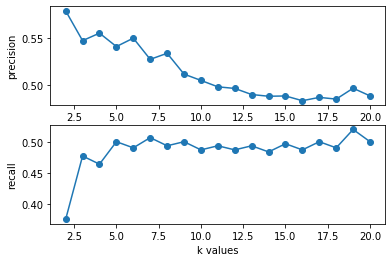

In [85]:
#visualize the KNN metrics
plt.subplot(2, 1, 1)
plt.plot(k_options, precisions, 'o-')
plt.xlabel('k values')
plt.ylabel('precision')

plt.subplot(2, 1, 2)
plt.plot(k_options, recalls, 'o-')
plt.xlabel('k values')
plt.ylabel('recall')

plt.show()

Text(0, 0.5, 'auc')

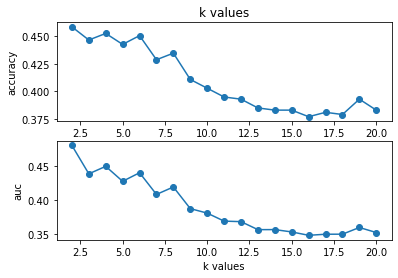

In [86]:
plt.subplot(2, 1, 1)
plt.plot(k_options, accuracies, 'o-')
plt.title('k values')
plt.ylabel('accuracy')

plt.subplot(2, 1, 2)
plt.plot(k_options, aucs, 'o-')
plt.xlabel('k values')
plt.ylabel('auc')

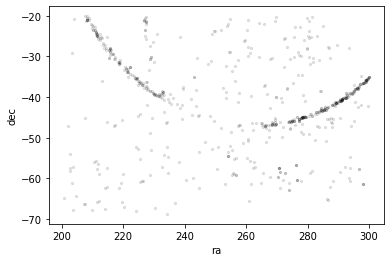

In [26]:
data_to_search.plot('ra', 'dec', kind='scatter', s=5, color='k', alpha=0.1)

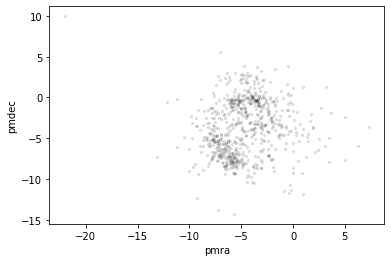

In [32]:
data_to_search.plot('pmra', 'pmdec', kind='scatter', s=5, color='k', alpha=0.1)

In [30]:
data_to_search.head()

,bp_g,bp_rp,dec,g_rp,parallax,parallax_error,phot_bp_mean_mag,phot_g_mean_mag,phot_rp_mean_mag,pmdec,pmdec_error,pmra,pmra_error,ra,radial_velocity,source_id,stream_mask
0,0.745995,1.695269,-57.387303,0.949274,-0.061400,0.505920,20.300377,19.554382,18.605108,-1.351866,NaN,-7.782657,NaN,202.740334,NaN,6.062642e+18,False
1,0.348001,1.389643,-67.445328,1.041641,-0.080276,0.508523,20.407013,20.059011,19.017370,-3.854532,NaN,-7.949487,NaN,214.005417,NaN,5.847820e+18,False
2,0.050575,1.174305,-30.680420,1.123730,0.147487,0.314326,18.344303,18.293728,17.169998,-7.539622,NaN,-2.123922,NaN,274.212945,NaN,4.049405e+18,False
3,-0.391691,1.616924,-25.163233,2.008615,0.131749,0.574607,19.043560,19.435251,17.426636,-4.444595,NaN,-3.810232,NaN,275.636451,NaN,4.053206e+18,False
4,0.713690,1.577223,-52.253712,0.863533,0.035587,0.263006,19.482328,18.768639,17.905106,-1.521764,NaN,-0.452264,NaN,224.245063,NaN,5.900131e+18,False


So we can see the overdensity by eye! Let's do some filtering.

Let's apply some filters. First: physics. "parallax" is the inverse of distance. Gaia measures parallaxes to stars. For stars that are >1 kpc (kiloparsec) away, the parallax measurement is very noisy. We know that most streams are far - say >5 kpc. Thus, we can apply a filter that the parallaxes should be pretty noise:



In [31]:
data_to_search['parallax_over_error'] = data_to_search['parallax'] / data_to_search['parallax_error']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab305ef450>]],
      dtype=object)

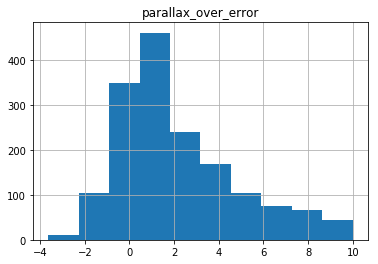

In [42]:
data_to_search.query('parallax_over_error < 10').hist('parallax_over_error')

Let's say that we want the noisiest data: only data with parallax/error < 0.5:

In [44]:
clean_data = data_to_search.query('parallax_over_error < 0.5')

Now, let's see if HDBSCAN picks it up:

In [45]:
!pip install -q hdbscan

In [46]:
axes_to_use = ['ra', 'dec', 'pmra', 'pmdec']
label = 'stream_mask'

X = np.array(clean_data[axes_to_use])
y = np.array(clean_data[label])

In [47]:
from hdbscan import HDBSCAN

In [48]:
db = HDBSCAN(metric='euclidean')

In [49]:
out_y = db.fit_predict(X)

In [50]:
np.unique(out_y)

array([-1,  0,  1,  2])

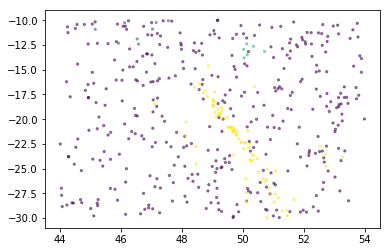

In [62]:
plt.scatter(X[:, 0], X[:, 1], s=5, c=out_y, alpha=0.5)

Indeed we can see a strip of yellow stars that resembles a stream. Let's take a closer look at label vs true label:

Text(0.5,0,'HDBSCAN Cluster (-1 is noise)')

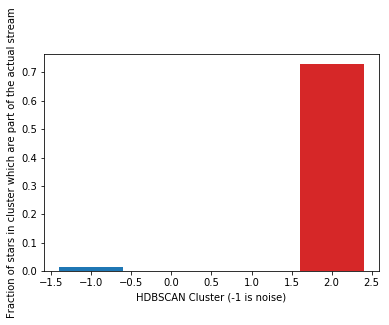

In [63]:
for cur_label in np.unique(out_y):
    mask = out_y == cur_label
    plt.bar(cur_label, y[mask].sum()/mask.sum())

plt.ylabel('Fraction of stars in cluster which are part of the actual stream')
plt.xlabel('HDBSCAN Cluster (-1 is noise)')

Stuff to test:

- What metrics work well for HDBSCAN?
- What works well for many different streams? (Maybe write a framework to test an algorithm on ~100 streams)?
- Can you try a supervised algorithm to learn to cluster in ra/dec/pmra/pmdec space (as above), and then try on a different stream and detect it?